C:\Users\mickm\AppData\Local\Temp\ipykernel_15900\3878440662.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  HRPlot.show()


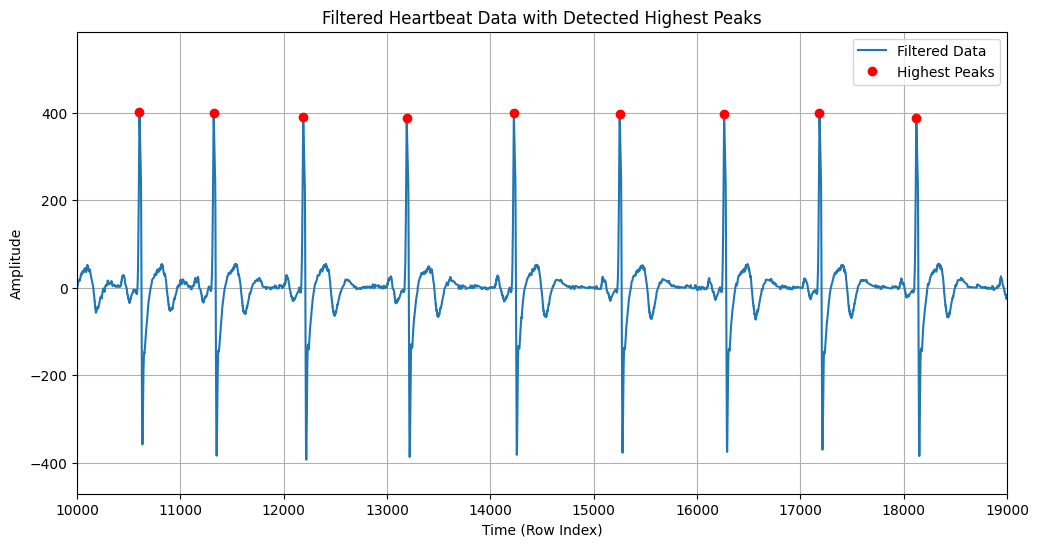

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor, Button
from scipy import signal
import math


# Define the path to your .txt file
file_path = "data\Research_B\Data\E(N35)V.txt"  # Replace with the actual file path

# Initialize variables to keep track of the highest peaks
highest_peak_values = []
highest_peak_indices = []

# Initialize variables to store the data rows
data = []
RMSSD = []


# Open and read the .txt file
with open(file_path, 'r') as file:
    data_started = False  # Flag to indicate when the data begins
    for line in file:
        # Check if the line contains the data
        if data_started:
            # Split each line into values (assuming space-separated)
            values = line.strip().split()
            # Append the values as integers or floats to your data list
            data.append([int(val) for val in values])
        # Check if the line contains the end of the header
        elif line.strip() == "# EndOfHeader":
            data_started = True  # Set the flag to True to indicate the start of data

# Convert the data into a NumPy array for further processing
data = np.array(data)

# Define the data column containing the heartbeat values
heartbeat_data = data[:, 2]

# Find peaks in the original heartbeat data (unfiltered)
# You may need to adjust the threshold as needed for the unfiltered data
heightthreshold = 200  # Adjust this threshold as needed
widthtreshold = 200


#Butterworth filter
sos = signal.butter(2, 3, 'highpass',fs = 1000, output = 'sos')
filtered = signal.sosfilt(sos, heartbeat_data)

# Create an array for the x-axis (time)
time = np.arange(len(heartbeat_data))

peaks, _ = signal.find_peaks(filtered, height=heightthreshold, distance= widthtreshold)

# Plot the original data
HRPlot = plt.figure(figsize=(12, 6))
plt.plot(time, filtered, label='Filtered Data')

# Plot the detected highest peaks on the original data
plt.plot(peaks, filtered[peaks], 'ro', label='Highest Peaks')
plt.xlabel('Time (Row Index)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Filtered Heartbeat Data with Detected Highest Peaks')
plt.grid(True)
plt.xlim(10000,19000)
# Show the plot
HRPlot.show()

C:\Users\mickm\AppData\Local\Temp\ipykernel_15900\291216784.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  RMSSDPlot2.show()


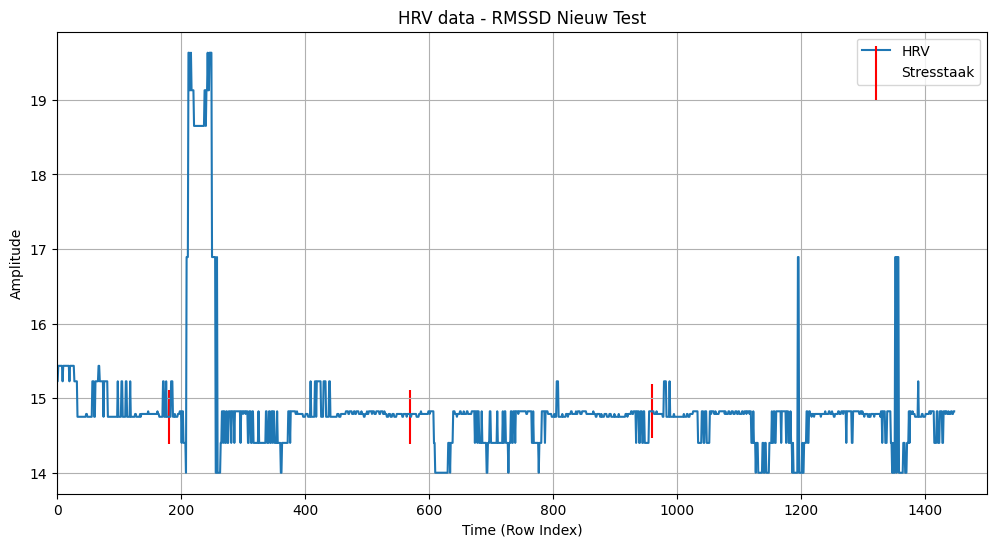

In [31]:
#--------------------- Nieuwe berekening -------------------------

interval = 29000  # Meettijd per HRV waarde (ms)
waarde1 = 0
waarde2 = interval

def calculate_rmssd(heartbeat_data, peaks):
    HRVRMSSD = []
    waarde1 = 0
    waarde2 = interval
    
    for i in range(int((len(heartbeat_data) - interval) / 1000)):
        peaks_in_range_interval = [peak for peak in peaks if waarde1 <= peak <= waarde2]
        RMSSD = [math.pow(heartbeat_data[peaks[j+1]] - heartbeat_data[peaks[j]], 2) for j, peak in enumerate(peaks_in_range_interval)]
        HRVcount = sum(RMSSD)
        HRVRMSSD.append(HRVcount / (len(peaks_in_range_interval) - 1))
        waarde1 += 1000
        waarde2 += 1000
    
    return HRVRMSSD

# Voer de functie uit om HRVRMSSD te berekenen
HRVRMSSD = calculate_rmssd(heartbeat_data, peaks)

# Plot de HRV data met de RMSSD formule
RMSSDPlot2 = plt.figure(figsize=(12, 6))
plt.plot(HRVRMSSD, label='HRV')
plt.xlabel('Time (Row Index)')
plt.ylabel('Amplitude')
plt.title('HRV data - RMSSD Nieuw Test')
plt.grid(True)
plt.xlim(0, 1500)
plt.scatter([180, 570, 960], [HRVRMSSD[180], HRVRMSSD[570], HRVRMSSD[960]], c='red', label='Stresstaak', s=1500, marker='|')
plt.legend()
RMSSDPlot2.show()  

C:\Users\mickm\AppData\Local\Temp\ipykernel_15900\3234458129.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  RMSSDPlot.show()


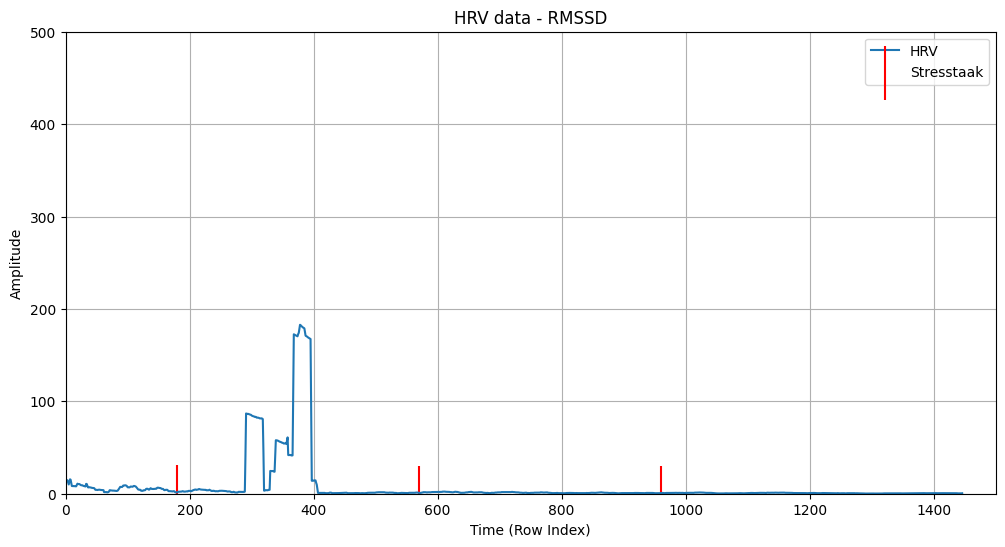

In [32]:
interval = 30000 #Meettijd per HRV waarde (ms)

#Calculate HRV with RMSSD


HRVRMSSD = []
HRVcount = 0
q = 0

peaks_in_range_interval = 0
peaks_in_range_interval2 = len([peak for peak in peaks if waarde1 <= peak <= waarde2])

for i in range(int((len(heartbeat_data)-interval)/1000)):
    #Neem de kwadraten van de verschillen tussen de waardes
    for j in range(peaks_in_range_interval, peaks_in_range_interval2):
        RMSSD.append(math.pow(heartbeat_data[peaks[peaks_in_range_interval+q+1]] - heartbeat_data[peaks[peaks_in_range_interval+q]], 2)) #heartbeat_data vervangen door pieken
        q = q+1

    #Tel verkregen waardes bij elkaar op
    HRVcount = sum(RMSSD)

    #Deel deze waarde door het totaal aantal waardes -1
    HRVRMSSD.append(HRVcount/(peaks_in_range_interval2-1))

    #Reset variabelen
    HRVcount = 0
    q = 0
    RMSSD = []
    
    #Verschuif het window met 1 seconden (1000 ms)
    waarde1 = waarde1 + 1000
    waarde2 = waarde2 + 1000
    peaks_in_range_interval = len([peak for peak in peaks if 0 <= peak <= waarde1])
    peaks_in_range_interval2 = len([peak for peak in peaks if 0 <= peak <= waarde2])
    
#plot de HRV data met de RMSSD formule
RMSSDPlot = plt.figure(figsize=(12, 6))
plt.plot(HRVRMSSD, label='HRV')
plt.xlabel('Time (Row Index)')
plt.ylabel('Amplitude')
plt.title('HRV data - RMSSD')
plt.grid(True)
plt.xlim(0,1500)
plt.ylim(0,500)
plt.scatter([180, 570, 960], [HRVRMSSD[180], HRVRMSSD[570], HRVRMSSD[960]], c='red', label='Stresstaak', s=1500, marker='|')
plt.legend()
RMSSDPlot.show()

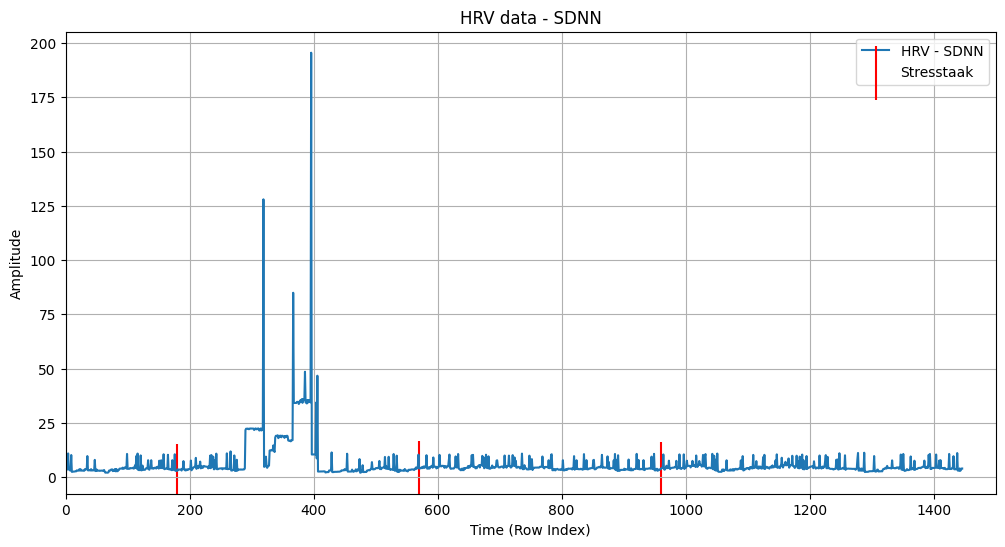

In [33]:
#Calculate HRV with SDNN


HRVcount = 0
q = 0
waarde1 = 0
waarde2 = interval
peaks_in_range_interval = 0
peaks_in_range_interval2 = len([peak for peak in peaks if waarde1 <= peak <= waarde2])

SDNNGem = 0
SDNN = []
HRVSDNN = []
SDNNV = 0

r=0

for i in range(int((len(heartbeat_data)-interval)/1000)):
    #Tel meetwaardes bij elkaar op en deel deze door het aantal waardes om het gemiddelde te berekenen.
    for j in range(peaks_in_range_interval, peaks_in_range_interval2):
        SDNNGem += heartbeat_data[peaks[peaks_in_range_interval]]
    SDNNGem = SDNNGem/(peaks_in_range_interval2 - peaks_in_range_interval)

    #Bereken de afwijking per meetwaarde ten opzichte van het gemiddelde en neem hier het kwadraat van
    for g in range(peaks_in_range_interval, peaks_in_range_interval2):
        SDNN.append(math.pow(heartbeat_data[peaks[peaks_in_range_interval+r]] - SDNNGem, 2)) #heartbeat_data vervangen door pieken
        r = r+1

    #Tel de gekwadrateerde afwijkingen bij elkaar op en deel deze door het aantal meet meetwaardes, en neem hier vervolgens de wortel van
    for z in range(len(SDNN)):
        SDNNV += SDNN[z]
    HRVSDNN.append(math.sqrt(SDNNV/len(SDNN)))

    #Reset variabelen
    r = 0
    SDNNGem = 0
    SDNNV = 0
    SDNN = []

    #Verschuif het window met 1 seconden (1000 ms)
    waarde1 = waarde1 + 1000
    waarde2 = waarde2 + 1000
    peaks_in_range_interval = len([peak for peak in peaks if 0 <= peak <= waarde1])
    peaks_in_range_interval2 = len([peak for peak in peaks if 0 <= peak <= waarde2])



plt.figure(figsize=(12, 6))
plt.plot(HRVSDNN, label='HRV - SDNN')
plt.xlabel('Time (Row Index)')
plt.ylabel('Amplitude')
plt.title('HRV data - SDNN')
plt.grid(True)
plt.xlim(0,1500)
plt.scatter([180, 570, 960], [HRVSDNN[180], HRVSDNN[570], HRVSDNN[960]], c='red', label='Stresstaak', s=1500, marker='|')
plt.legend()
plt.show()